# Project Title
### Data Engineering Capstone Project

#### Project Summary
--describe your project at a high level--

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
# Do all imports and installs here
import pandas as pd
import datetime
import configparser
import psycopg2

### Step 1: Scope the Project and Gather Data

#### Scope 
This project enables users to find patterns in migration data and corellations between migration and the effects of global worming in the contries of origin. Therefore it provides data on monthly migration into the usa and data on the temperature of the migrants home contries. The data is provided on AWS Redshift. In a first step the raw data is uploaded to an aws s3 blob storage, from there the raw data is copied into staging tables on aws redshift. The data in the staging tables is transformed to be provided in the dimension and fact tables. The detailed data model is described in 'Step 3: Define the Data Model'

#### Describe and Gather Data 
The data used in this porject comes from different sources: 

##### World Temperature Data

The data contaions the average temperature and the average temperature Uncertainty per city, month and year. It also contains the country in which the city is located and its longitude and latitude. For this Project the columns "dt",  "AverageTemperature", "City" and "Country" will be relevant. The data is used to calculate the average temperature per contry per month. 

Data source: https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data

In [2]:
# explore World Temoperature Data 
world_temp_df = pd.read_csv("../../data2/GlobalLandTemperaturesByCity.csv")
world_temp_df.head(5)

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [3]:
# # wirte csv to workspace
# world_temp_df.to_csv("GlobalLandTemperaturesByCity.csv")

##### I94 Immigration Data

Data provided by the US National Tourism and Trade Office containing information on immigration to the USA. Relevant information from that data source: 
- cicid = Unique ID
- i94yr	year
- i94mon	month
- i94cit	3 digit code for immigrant country of birth
- i94res	3 digit code for immigrant country of residence
- arrdate	Arrival Date in the USA
- depdate	Departure Date from the USA
- i94bir	Age of Respondent in Years
- i94visa	Visa codes collapsed into three categories
- count	Field used for summary statistics
- dtadfile	Character Date Field - Date added to I-94 Files
- visapost	Department of State where where Visa was issued
- entdepd	Departure Flag - Departed, lost I-94 or is deceased
- entdepu	Update Flag - Either apprehended, overstayed, adjusted to perm residence
- dtaddto	Character Date Field - Date to which admitted to U.S. (allowed to stay until)
- visatype	Class of admission legally admitting the non-immigrant to temporarily stay in U.S.


In [4]:
# explore immigration data
imigration_df = pd.read_sas('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat', 'sas7bdat', encoding="ISO-8859-1")
imigration_df.head(5)

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,6.0,2016.0,4.0,692.0,692.0,XXX,20573.0,NaN,NaN,NaN,...,U,NaN,1979.0,10282016,NaN,NaN,NaN,1.897628e+09,NaN,B2
1,7.0,2016.0,4.0,254.0,276.0,ATL,20551.0,1.0,AL,NaN,...,Y,NaN,1991.0,D/S,M,NaN,NaN,3.736796e+09,00296,F1
2,15.0,2016.0,4.0,101.0,101.0,WAS,20545.0,1.0,MI,20691.0,...,NaN,M,1961.0,09302016,M,NaN,OS,6.666432e+08,93,B2
3,16.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,NaN,M,1988.0,09302016,NaN,NaN,AA,9.246846e+10,00199,B2
4,17.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,NaN,M,2012.0,09302016,NaN,NaN,AA,9.246846e+10,00199,B2


In [5]:
# relevant columns
imigration_df[[
"cicid","i94yr","i94mon","i94cit","i94res","arrdate","depdate","i94bir","i94visa",
    "count","dtadfile","visapost","entdepd","entdepu","dtaddto","visatype"]].head(5)

,cicid,i94yr,i94mon,i94cit,i94res,arrdate,depdate,i94bir,i94visa,count,dtadfile,visapost,entdepd,entdepu,dtaddto,visatype
0,6.0,2016.0,4.0,692.0,692.0,20573.0,NaN,37.0,2.0,1.0,NaN,NaN,NaN,U,10282016,B2
1,7.0,2016.0,4.0,254.0,276.0,20551.0,NaN,25.0,3.0,1.0,20130811,SEO,NaN,Y,D/S,F1
2,15.0,2016.0,4.0,101.0,101.0,20545.0,20691.0,55.0,2.0,1.0,20160401,NaN,O,NaN,09302016,B2
3,16.0,2016.0,4.0,101.0,101.0,20545.0,20567.0,28.0,2.0,1.0,20160401,NaN,O,NaN,09302016,B2
4,17.0,2016.0,4.0,101.0,101.0,20545.0,20567.0,4.0,2.0,1.0,20160401,NaN,O,NaN,09302016,B2


In [6]:
imigration_df[['i94yr','i94mon', "depdate", "occup", "dtaddto", "gender"]].head(15)

,i94yr,i94mon,depdate,occup,dtaddto,gender
0,2016.0,4.0,NaN,NaN,10282016,NaN
1,2016.0,4.0,NaN,NaN,D/S,M
2,2016.0,4.0,20691.0,NaN,09302016,M
3,2016.0,4.0,20567.0,NaN,09302016,NaN
4,2016.0,4.0,20567.0,NaN,09302016,NaN
5,2016.0,4.0,20555.0,NaN,09302016,NaN
6,2016.0,4.0,20558.0,NaN,09302016,NaN
7,2016.0,4.0,20558.0,NaN,09302016,NaN
8,2016.0,4.0,20553.0,NaN,09302016,NaN
9,2016.0,4.0,20562.0,NaN,09302016,NaN


##### Airport Codes
Contains informatin on airports such as the airport code and the corespondig city. 

In [7]:
# Explore Airport Code Data
airport_code_df = pd.read_csv("airport-codes_csv.csv")
airport_code_df.head(5)

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"


In [8]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.\
config("spark.jars.repositories", "https://repos.spark-packages.org/").\
config("spark.jars.packages", "saurfang:spark-sas7bdat:2.0.0-s_2.11").\
enableHiveSupport().getOrCreate()

df_spark = spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat')
print("done")

done


In [9]:
# #write to parquet
# df_spark.write.mode("overwrite").parquet("sas_data")
# df_spark=spark.read.parquet("sas_data")

### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

#### Cleaning Steps
Document steps necessary to clean the data

In [11]:
print(type(world_temp_df))

<class 'pandas.core.frame.DataFrame'>


In [12]:
# Identify data quality issues in World Temperature Data 
# 1) chech for duplicate rows
duplicates = world_temp_df.duplicated()
count_duplicates = len(duplicates.loc[lambda x : x == True])
if count_duplicates > 0: 
    print(count_duplicates, "duplicates found")
else:
    print("no duplicates found")

# 2) find columns with <90% missing values 
check_nan = world_temp_df.isnull().sum()*100 / len(world_temp_df) 
print("\n percentage of nan values per column \n", check_nan)

no duplicates found

 percentage of nan values per column 
 dt                               0.000000
AverageTemperature               4.234458
AverageTemperatureUncertainty    4.234458
City                             0.000000
Country                          0.000000
Latitude                         0.000000
Longitude                        0.000000
dtype: float64


In [13]:
# Identify data quality issues in immigration data

# 1) chech for duplicate rows
duplicates = imigration_df.duplicated()
count_duplicates = len(duplicates.loc[lambda x : x == True])
if count_duplicates > 0: 
    print(count_duplicates, "duplicates found")
else:
    print("no duplicates found")

# 2) find columns with <90% missing values 
check_nan = imigration_df.isnull().sum()*100 / len(imigration_df) 
print("\n percentage of nan values per column \n", check_nan)


no duplicates found

 percentage of nan values per column 
 cicid        0.000000
i94yr        0.000000
i94mon       0.000000
i94cit       0.000000
i94res       0.000000
i94port      0.000000
arrdate      0.000000
i94mode      0.007719
i94addr      4.921079
depdate      4.600859
i94bir       0.025902
i94visa      0.000000
count        0.000000
dtadfile     0.000032
visapost    60.757746
occup       99.737559
entdepa      0.007687
entdepd      4.470769
entdepu     99.987340
matflag      4.470769
biryear      0.025902
dtaddto      0.015405
gender      13.379429
insnum      96.327632
airline      2.700857
admnum       0.000000
fltno        0.631364
visatype     0.000000
dtype: float64


In [14]:
# Identify data quality issues in Airport Code Data

# 1) chech for duplicate rows
duplicates = airport_code_df.duplicated()
count_duplicates = len(duplicates.loc[lambda x : x == True])
if count_duplicates > 0: 
    print(count_duplicates, "duplicates found")
else:
    print("no duplicates found")

# 2) find columns with <90% missing values 
check_nan = airport_code_df.isnull().sum()*100 / len(airport_code_df) 
print("\n percentage of nan values per column \n", check_nan)


no duplicates found

 percentage of nan values per column 
 ident            0.000000
type             0.000000
name             0.000000
elevation_ft    12.720835
continent       50.329551
iso_country      0.448479
iso_region       0.000000
municipality    10.305946
gps_code        25.501589
iata_code       83.315479
local_code      47.914662
coordinates      0.000000
dtype: float64


In [15]:
# clean World Temperature Data 

# 1) drop duplicates -> not needed 
# 2) drop columns with > 60 % nan values -> not needed 
# 3) Transform data types
# # 3.1) transform timestamp to datetime format 
world_temp_df["dt"] = pd.to_datetime(world_temp_df["dt"])
print("datatypes in df: \n", world_temp_df.dtypes)


datatypes in df: 
 dt                               datetime64[ns]
AverageTemperature                      float64
AverageTemperatureUncertainty           float64
City                                     object
Country                                  object
Latitude                                 object
Longitude                                object
dtype: object


In [16]:
# clean World Temperature Data 

# 1) drop duplicates -> not needed 
# 2) drop columns with > 60 % nan values
check_nan = imigration_df.isnull().sum()*100 / len(imigration_df) 
col_to_drop = list(check_nan[check_nan>60].index)
imigration_df = imigration_df.drop(columns=col_to_drop)
print(imigration_df.head(5))

# 3) Transform data types -> not needed
print("datatypes in df: \n", imigration_df.dtypes)

   cicid   i94yr  i94mon  i94cit  i94res i94port  arrdate  i94mode i94addr  \
0    6.0  2016.0     4.0   692.0   692.0     XXX  20573.0      NaN     NaN   
1    7.0  2016.0     4.0   254.0   276.0     ATL  20551.0      1.0      AL   
2   15.0  2016.0     4.0   101.0   101.0     WAS  20545.0      1.0      MI   
3   16.0  2016.0     4.0   101.0   101.0     NYC  20545.0      1.0      MA   
4   17.0  2016.0     4.0   101.0   101.0     NYC  20545.0      1.0      MA   

   depdate   ...     entdepa  entdepd  matflag biryear   dtaddto gender  \
0      NaN   ...           T      NaN      NaN  1979.0  10282016    NaN   
1      NaN   ...           G      NaN      NaN  1991.0       D/S      M   
2  20691.0   ...           T        O        M  1961.0  09302016      M   
3  20567.0   ...           O        O        M  1988.0  09302016    NaN   
4  20567.0   ...           O        O        M  2012.0  09302016    NaN   

  airline        admnum  fltno visatype  
0     NaN  1.897628e+09    NaN       B

In [17]:
# clean Airport Code Data

# 1) drop duplicates -> not needed 
# 2) drop columns with > 60 % nan values
check_nan = airport_code_df.isnull().sum()*100 / len(airport_code_df) 
col_to_drop = list(check_nan[check_nan>60].index)
airport_code_df = airport_code_df.drop(columns=col_to_drop)
print(airport_code_df.columns, airport_code_df.head(5))

# 3) Transform data types -> not needed
print("datatypes in df: \n", airport_code_df.dtypes)

Index(['ident', 'type', 'name', 'elevation_ft', 'continent', 'iso_country',
       'iso_region', 'municipality', 'gps_code', 'local_code', 'coordinates'],
      dtype='object')   ident           type                                name  elevation_ft  \
0   00A       heliport                   Total Rf Heliport          11.0   
1  00AA  small_airport                Aero B Ranch Airport        3435.0   
2  00AK  small_airport                        Lowell Field         450.0   
3  00AL  small_airport                        Epps Airpark         820.0   
4  00AR         closed  Newport Hospital & Clinic Heliport         237.0   

  continent iso_country iso_region  municipality gps_code local_code  \
0       NaN          US      US-PA      Bensalem      00A        00A   
1       NaN          US      US-KS         Leoti     00AA       00AA   
2       NaN          US      US-AK  Anchor Point     00AK       00AK   
3       NaN          US      US-AL       Harvest     00AL       00AL   
4     

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model

The performed analysis / business process is focused on migration patterns, therefore the data about immigration is provided in the 'immigration_fact' table. The data is generated by the business process of permitting migrants to enter the country. Each row in the fact tabe represents the single occurence of a migrant entering the United States ("Grain"). 

Several dimension tables are provided to provide context and to analyse the data in the 'immigration_fact' table:
- 'climate_dim' contains information on the crlimate in the immigrants country of origin.
- 'visa_dim' contains information about the type of visa used 
- 'status_dim' contains information on the immigration status 
- 'time_dim' provides time diomension
- 'country_dim" can be used to map  country codes to country names

All the tables are provided in a star schema to enable good query performance for OLAP (Online Analytical Processing).  

The image of the db schema was created using https://dbdiagram.io/. 
https://dbdiagram.io/d/64ef2d8f02bd1c4a5ead1617


#### Tables: 

immigration_fact: 
- immigration_id 
- visa_id
- status_id
- date_id from year and month
- temp_id
- transportatin_mode from i94mode
- arrival_state from i94addr
- country_residence from i94res
- airline from airline
- admission_number from admnum



immigratnt_dim: 
- immigration_id 
- gender 
- year_birth from i94bir
- occupation from occup
- country_birth from i94cit


dim_visa:
- visa_id from type and issuer
- visa_type from  i94visa
- visa_issuer from visapost

status_dim:
- status_id = visa_id
- arrival_flag from col. entdepa
- departure_flag from col. entdepd
- update_flag from col. entdepu
- match_flag from col. matflag

dim_time: 
- date_id
- day
- month
- year
- week
- weekday

temp_dim: 
- temp_id = YearMonth  
- year
- month 
- country
- avg_temp

country_dim:
- country_id
- country 



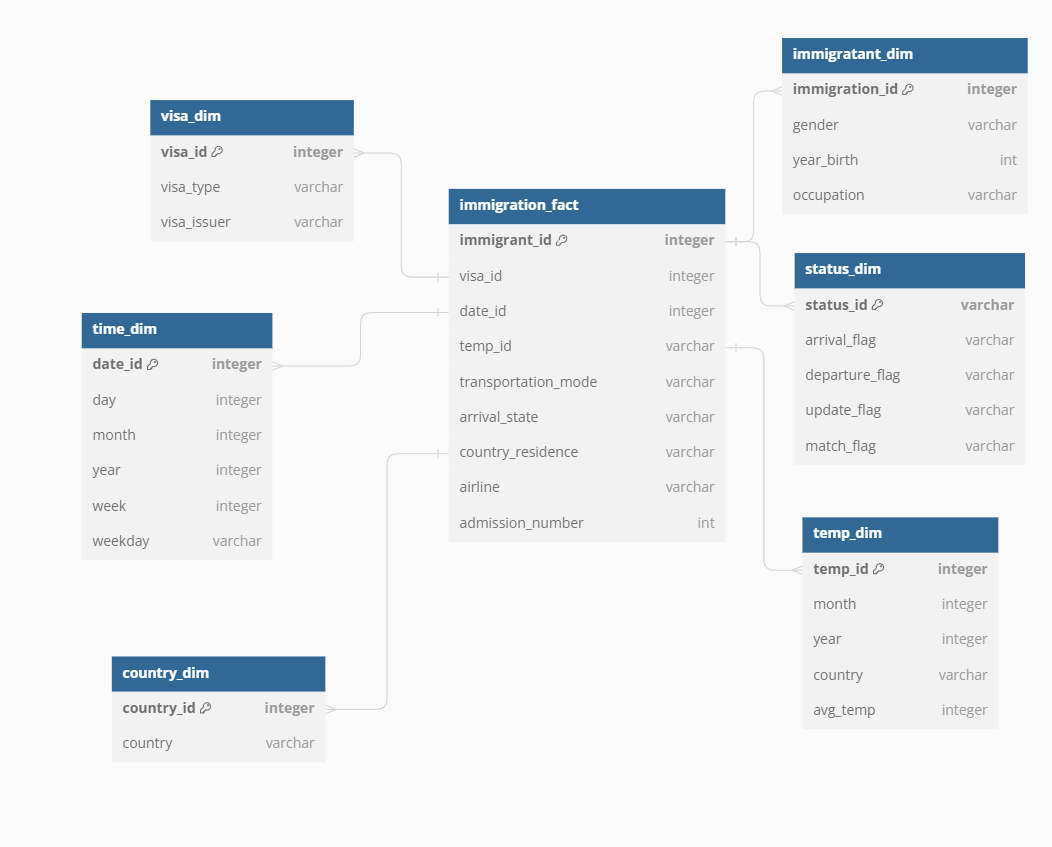

#### 3.2 Mapping Out Data Pipelines
List the steps necessary to pipeline the data into the chosen data model:

1) Create the staging, the dim and the fact tabeles in AWS Redshift 

2) Load data into the staging tabels 

3) Create dim and fact tabels from staging tabels

4) perform quality checks 


### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
This notebook assumes that a AWS Redshift Cluster is available and accessible using the data in 'dwh.cfg'. It is also assumed that the raw data is available in a AWS s3 storage that can be accessec using the IAM Role defined in  'dwh.cfg'.

In [2]:
# sql commands for table cration
staging_immigration_create = ("""
    CREATE TABLE IF NOT EXISTS immigration_staging (
        cicid       float,
        i94yr       float,
        i94mon      float,
        i94cit      float,
        i94res      float,
        i94port     varchar,
        arrdate     float,
        i94mode     float,
        i94addr     varchar,
        depdate     float,
        i94bir      float,
        i94visa     float,
        count       float,
        dtadfile    varchar,
        visapost    varchar,
        occup       varchar,
        entdepa     varchar,
        entdepd     varchar,
        entdepu     varchar,
        matflag     varchar,
        biryear     float,
        dtaddto     varchar,
        gender      varchar,
        insnum      varchar,
        airline     varchar,
        admnum      float,
        fltno       varchar,
        visatype    varchar
        )
""")

staging_climate_create = ("""
    CREATE TABLE IF NOT EXISTS climate_staging (
        dt                               varchar,
        AverageTemperature               varchar,
        AverageTemperatureUncertainty    varchar,
        City                             varchar,
        Country                          varchar,
        Latitude                         varchar,
        Longitude                        varchar
        )
""")

# create fact tabel
fact_immigration_create = ("""
    CREATE TABLE IF NOT EXISTS immigration_fact (
    immigration_id integer,
    visa_id varchar,
    date_id varchar,
    temp_id varchar,
    transportatin_mode varchar,
    arrival_state varchar,
    country_residence varchar,
    airline varchar,
    admission_number BIGINT
        )
""")

# create dim tabels
dim_visa_create = ("""
    CREATE TABLE IF NOT EXISTS visa_dim (
    visa_id varchar,
    visa_type varchar,
    visa_issuer varchar
        )
""")

dim_time_create = ("""
    CREATE TABLE IF NOT EXISTS time_dim (
    date date,
    date_id integer,
    day integer,
    month integer,
    year integer,
    week integer,
    weekday varchar
        )
""")

dim_immigrant_create = ("""
    CREATE TABLE IF NOT EXISTS immigrant_dim (
    immigration_id integer,
    gender varchar,
    year_birth integer,
    occupation varchar,
    country_birth varchar
        )
""")


dim_status_create = ("""
    CREATE TABLE IF NOT EXISTS status_dim (
    status_id varchar,
    arrivl_flag varchar,
    departure_flag varchar,
    update_flag varchar,
    match_flag varchar
        )
""")


dim_temp_create = ("""
    CREATE TABLE IF NOT EXISTS temp_dim (
    temp_id varchar,
    month integer,
    year integer,
    country varchar,
    avg_temp float
        )
""")

dim_country_create = ("""
    CREATE TABLE IF NOT EXISTS country_dim (
    country_id INT,
    country varchar
        )
""")


# sql commands to ingest and transfrom data into dim and fact tables
immigrant_dim_insert = ("""
    INSERT INTO immigrant_dim
    SELECT cicid as immigration_id, gender as gender, i94bir as year_birth, occup as occupation, i94cit as country_birth
    FROM immigration_staging""")


visa_dim_insert = ("""
    INSERT INTO visa_dim
    SELECT DISTINCT CONCAT(i94visa, visapost) as visa_id, i94visa as visa_type, visapost as visa_issuer
    FROM immigration_staging 
    WHERE visa_id IS NOT NULL
""")

status_dim_insert = ("""
    INSERT INTO status_dim
    SELECT cicid as status_id, entdepa as arrival_flag, entdepd as departure_flag, entdepu  as update_flag, matflag as  match_flag
    FROM immigration_staging
""")

temp_dim_insert = ("""
    INSERT INTO temp_dim
    SELECT CONCAT(CONCAT(CAST(year as varchar), CAST(month as varchar)), country) as temp_id,  month, year, country, temp_avg
    FROM (
      SELECT  EXTRACT(year from CAST(dt as date)) as year, EXTRACT(month from CAST(dt as date)) as month, country, AVG(CAST(averagetemperature as float)) as temp_avg
      FROM climate_staging WHERE averagetemperature != ''
      GROUP BY  year, month, country                                                     
      limit(13)
       ) as subquery
""")

dim_time_insert = ("""
    INSERT INTO time_dim
    Select DISTINCT 
        CAST(dt AS date) as date,
        CAST (CONCAT (CAST(EXTRACT (YEAR from date) as INT), CAST(EXTRACT (Month from date) as INT) ) as INT) as date_id,
        EXTRACT (DAY from date) as day,
        EXTRACT (Month from date) as month,
        EXTRACT (YEAR from date) as year,
        EXTRACT (WEEK from date) as week,
        EXTRACT (DOW from date) as weekday
    from climate_staging

""")


fact_immigration_insert = ("""
    INSERT INTO immigration_fact 
    SELECT  cicid as immigration_id, CONCAT(i94visa, visapost) as visa_id, Concat(i94yr,i94mon) as date_id, Concat(Concat(i94yr,i94mon), country) as temp_id, i94mode as transportatin_mode, i94addr AS arrival_state, i94res as country_residence, airline as airline, admnum as admission_number
    FROM immigration_staging 
    JOIN country_dim on immigration_staging.i94res  = country_dim.country_id
""")



In [2]:
import configparser
import psycopg2

def execute_sql_query(sql_query):  
    '''
    execute a given sql command on aws redshift using the credentials in 'dwh.cfg'
    '''
    config = configparser.ConfigParser()
    config.read('dwh.cfg')
    conn = psycopg2.connect("host={} dbname={} user={} password={} port={}".format(*config['CLUSTER'].values()))
    cur = conn.cursor()
    cur.execute(sql_query)
    try:
        result = cur.fetchall()
        return(result)
    except Exception as e:
        print("executed sql command, no row to fetch: ", e )
    conn.commit()
    conn.close()
    print("connection closed")


In [4]:
# create all needed tables using the predefined sql commands:
execute_sql_query(staging_immigration_create)
execute_sql_query(staging_climate_create)
execute_sql_query(fact_immigration_create)
execute_sql_query(dim_visa_create)
execute_sql_query(dim_time_create)
execute_sql_query(dim_immigrant_create)
execute_sql_query(dim_temp_create)
execute_sql_query(dim_status_create)
execute_sql_query(dim_country_create)

print("tabel created")

executed sql command, no row to fetch:  no results to fetch
connection closed
executed sql command, no row to fetch:  no results to fetch
connection closed
executed sql command, no row to fetch:  no results to fetch
connection closed
executed sql command, no row to fetch:  no results to fetch
connection closed
executed sql command, no row to fetch:  no results to fetch
connection closed
executed sql command, no row to fetch:  no results to fetch
connection closed
executed sql command, no row to fetch:  no results to fetch
connection closed
executed sql command, no row to fetch:  no results to fetch
connection closed
executed sql command, no row to fetch:  no results to fetch
connection closed
tabel created


In [5]:
# copy climate date from s3 to redshift staging tables 
s3_path = 's3://s3-test-bucket-raw-data-dev/raw_data/GlobalLandTemperaturesByCity.csv'
config = configparser.ConfigParser()
config.read('dwh.cfg')
iam_role = config.get("IAM_Role", "ARN")
copy_climate = f""" COPY climate_staging FROM '{s3_path}' CREDENTIALS 'aws_iam_role={iam_role}' CSV DELIMITER ',' IGNOREHEADER 1"""
print("copy cmd:" ,copy_climate )
execute_sql_query(copy_climate)

copy cmd:  COPY climate_staging FROM 's3://s3-test-bucket-raw-data-dev/raw_data/GlobalLandTemperaturesByCity.csv' CREDENTIALS 'aws_iam_role=arn:aws:iam::356745425535:role/myRedshiftRole' CSV DELIMITER ',' IGNOREHEADER 1
executed sql command, no row to fetch:  no results to fetch
connection closed


In [6]:
# copy country data from s3 to redshift table
s3_path = 's3://s3-test-bucket-raw-data-dev/raw_data/I94CIT_I94RES.csv'
config = configparser.ConfigParser()
config.read('dwh.cfg')
iam_role = config.get("IAM_Role", "ARN")
copy_climate = f""" COPY country_dim FROM '{s3_path}' CREDENTIALS 'aws_iam_role={iam_role}' CSV DELIMITER ',' IGNOREHEADER 1"""
execute_sql_query(copy_climate)

arn:aws:iam::356745425535:role/myRedshiftRole
copy cmd:  COPY country_dim FROM 's3://s3-test-bucket-raw-data-dev/raw_data/I94CIT_I94RES.csv' CREDENTIALS 'aws_iam_role=arn:aws:iam::356745425535:role/myRedshiftRole' CSV DELIMITER ',' IGNOREHEADER 1
executed sql command, no row to fetch:  no results to fetch
connection closed


In [9]:
# copy immigration data from s3 to redshift 
s3_path = 's3://s3-test-bucket-raw-data-dev/raw_data/immigration_data/'
iam_role = config.get("IAM_Role", "ARN")
copy_immigration = f""" COPY immigration_staging FROM '{s3_path}' CREDENTIALS 'aws_iam_role={iam_role}'FORMAT AS PARQUET"""
execute_sql_query(copy_climate)

executed sql command, no row to fetch:  no results to fetch
connection closed


In [4]:
# transform and load data from staging to dim and fact tables 
execute_sql_query(visa_dim_insert)
execute_sql_query(immigrant_dim_insert)
execute_sql_query(status_dim_insert)
execute_sql_query(temp_dim_insert)
execute_sql_query(fact_immigration_insert)
execute_sql_query(dim_time_insert)

executed sql command, no row to fetch:  no results to fetch
connection closed
executed sql command, no row to fetch:  no results to fetch
connection closed
executed sql command, no row to fetch:  no results to fetch
connection closed
executed sql command, no row to fetch:  no results to fetch
connection closed
executed sql command, no row to fetch:  no results to fetch
connection closed
executed sql command, no row to fetch:  no results to fetch
connection closed


#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

#### Check if the data is available in dim and fact tables. 

In [5]:
def row_count(tbl_name):
    row_count = f"""SELECT COUNT(*) FROM {tbl_name}"""
    result = execute_sql_query(row_count)
    return result[0]

# quality check 1: do tables exist: 
select_tbls = """
    SELECT tablename
    FROM pg_tables
    WHERE schemaname = 'public'
"""
tables = execute_sql_query(select_tbls)

# data quality check 1: Do the tables exist?
if len(tables) <1: 
     raise ValueError (f"Data Quality check failer.Database contains no tables")    
else: 
    print(f"Data Quality check 1 passed: database contains {len(tables)} tables")
    # data quality check 2: Do the tables contain data?
    for element in tables:
        table = (element[0])
        row_count = execute_sql_query(f"""SELECT COUNT(*) FROM {table}""")[0][0]
        if row_count < 1:
            raise ValueError (f"Data Quality 2 check failed. {table} contains {row_count} rows")
        else:
            print(f"Data Quality check 2 passed: {table} contains {row_count} rows")

      

Data Quality check 1 passed: database contains 9 tables
Data Quality check 2 passed: immigration_staging contains 3096313 rows
Data Quality check 2 passed: country_dim contains 1156 rows
Data Quality check 2 passed: climate_staging contains 17198424 rows
Data Quality check 2 passed: visa_dim contains 1212 rows
Data Quality check 2 passed: time_dim contains 6478 rows
Data Quality check 2 passed: immigrant_dim contains 3096313 rows
Data Quality check 2 passed: status_dim contains 3096313 rows
Data Quality check 2 passed: immigration_fact contains 12385252 rows
Data Quality check 2 passed: temp_dim contains 26 rows


#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

immigration_fact: 
- immigration_id: Unique identifier (PK)
- visa_id: Unique identifier (FK)
- status_id: Unique identifier (FK)
- date_id: Unique identifier (FK)
- temp_id: Unique identifier (FK)
- transportatin_mode: Mode of transportation (from i94mode in immigration_staging; 1 = Air; 2 = Sea; 3 = Land; 9 = Not reported)
- arrival_state: USA State of arrival (from i94addr in immigration_staging)
- country_residence: 3 digit code for immigrant country of residence (from i94res immigration_staging) (FK)
- airline:  Airline used to arrive in U.S. (from airline in immigration_staging)
- admission_number: Number of admission (from admnum in immigration_staging)



immigratnt_dim: 
- immigration_id:  Unique Identifier (PK)
- gender: Gener (from immigration_staging)
- year_birth: Year of birth (from i94bir in immigration_staging)
- occupation: Occupation (from occup in immigration_staging)
- country_birth: COuntry of birth (from i94cit in immigration_staging)


dim_visa:
- visa_id: Unique Identifier (PK)
- visa_type: Type of visa (from  i94visa in immigration_staging)
- visa_issuer: Issuer of visa (from visapost in immigration_staging)

status_dim:
- status_id: Unique identifier (PK)
- arrival_flag: Arrival Flag - admitted or paroled into the U.S. (from entdepa in immigration_staging)
- departure_flag: Departure Flag - Departed, lost I-94 or is deceased (from entdepd in immigration_staging)
- update_flag: Update Flag (from entdepu in immigration_staging)
- match_flag:  Match flag - Match of arrival and departure records (from matflag in immigration_staging)

dim_time: 
- date_id: Unique identifier (PK)
- day: Day
- month: Month
- year: Year
- week: Week
- weekday: Day of Week

temp_dim: 
- temp_id: Unique Identifier (PK)  
- year: Year
- month: Month
- country: Countrty
- avg_temp: Average temperature per month and country

country_dim:
- country_id: Unique Identifier (PK)  
- country: Name of the country


#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
* Propose how often the data should be updated and why.
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 * The database needed to be accessed by 100+ people.

#### 1) Clearly state the rationale for the choice of tools and technologies for the project
This project uses different technologise to make it easy to get insights on immigration patterns: 
- AWS Redshift is used to provide fast data access and to provide  scalabilitie if the amount of data increases in the future
- AWS S3 is used to store the raw data
- SQL statements are used to create tables on redshift. They are also used to transform and load data. 
- Pandas is used to explore the data.
- Apache Spark is used to process big amounts of data.

#### 2) Propose how often the data should be updated and why.
Since the immigration dataset is updated monthly, the data should be updated monthly as well. 

#### 3) Write a description of how you would approach the problem differently under the following scenarios:
##### 3a) The data was increased by 100x.
If the Data would increase by 100x the Redshift Redshift Cluster should be scaled up to provide more storage and compute performance. If necessary to handle the bigger amount of data an AWS ERM cluster could be used for distributed data processing with spark. 
##### 3b) The data populates a dashboard that must be updated on a daily basis by 7am every day.
Apache Airflow could be used to built and trigger ETL Pipelines. Thous Pipelines could be set to run every morning befor 7am to make sure the dashboard is ready to use at 7 am.
##### 3c)  The database needed to be accessed by 100+ people.
If the used Redshift Cluster can't handle the requests by 100+ people it shuold be upgraded to a bigger instance. 